# 基础因子实时计算

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from PyFin.api import *
from alphamind.api import *
from conf.models import *
from conf.config import*
from alphamind.execution.naiveexecutor import NaiveExecutor
from stacking import factor_store, feature_list
from optimization.bayes_optimization_xgb import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

# 因子数据库
data_source = alpha_db
engine = SqlEngine(data_source)

## 因子数据准备

In [2]:
universe = Universe('zz500')
freq = '5b'
benchmark_code = 905
# start_date = '2010-01-19'  # 训练集的起始时间
start_date = '2019-10-16'  # 训练集的起始时间
end_date = '2019-12-18'
ref_dates = makeSchedule(start_date, end_date, freq, 'china.sse')
horizon = map_freq(freq)
industry_name = 'sw'
industry_level = 1
ref_dates

[datetime.datetime(2019, 10, 16, 0, 0),
 datetime.datetime(2019, 10, 23, 0, 0),
 datetime.datetime(2019, 10, 30, 0, 0),
 datetime.datetime(2019, 11, 6, 0, 0),
 datetime.datetime(2019, 11, 13, 0, 0),
 datetime.datetime(2019, 11, 20, 0, 0),
 datetime.datetime(2019, 11, 27, 0, 0),
 datetime.datetime(2019, 12, 4, 0, 0),
 datetime.datetime(2019, 12, 11, 0, 0),
 datetime.datetime(2019, 12, 18, 0, 0)]

In [3]:
# 前一个调仓日, 用于获取前一个调仓日的持仓信息
ref_date_pre = ref_dates[-2]
# 当前调仓日
ref_date = ref_dates[-1]
ref_date, ref_date_pre

(datetime.datetime(2019, 12, 18, 0, 0), datetime.datetime(2019, 12, 11, 0, 0))

In [4]:
# uqer因子列表
basic_factor_store = factor_store.basic_factor_store
# alpha191因子列表
alpha_factor_store = factor_store.alpha_factor_store

In [5]:
%%time
# 提取Uqer因子
basic_factor_org = engine.fetch_factor_range(universe, basic_factor_store, dates=ref_dates)
# 提取alpha191因子
# alpha191_factor_org = engine.fetch_factor_range(universe, 
#                                                 alpha_factor_store, 
#                                                 dates=ref_dates, 
#                                                 used_factor_tables=[Alpha191]).drop(['chgPct','secShortName'], axis=1)
# # 合并所有的因子
# factor_data_org = pd.merge(basic_factor_org, alpha191_factor_org, on=['trade_date', 'code'], how='outer')
factor_data_org = basic_factor_org


CPU times: user 9.36 s, sys: 263 ms, total: 9.63 s
Wall time: 10.8 s


In [6]:
len(set(factor_data_org['trade_date']))


10

Text(0, 0.5, 'ACCA')

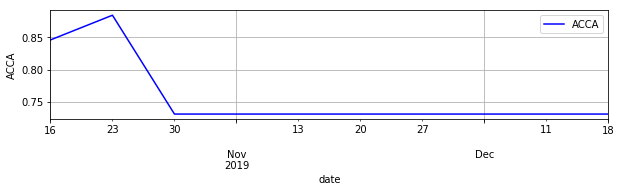

In [7]:
# Plot factor value over time on code
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 2 # width 10, height 8

ax = factor_data_org[factor_data_org['code'] == 6].plot(x='trade_date', y='ACCA', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("ACCA")

In [8]:
# 因子预处理
## 确失值填充
factor_mean = factor_data_org.mean()
factor_std = factor_data_org.std()
factor_data_org = factor_data_org.fillna(factor_mean)

In [9]:
%%time
# 获取所属行业
industry = engine.fetch_industry_range(universe, dates=ref_dates)
# factor_data = pd.merge(factor_data_org, industry, on=['trade_date', 'code']).fillna(0.)
factor_data = pd.merge(factor_data_org, industry, on=['trade_date', 'code'])

# 获取风险因子
risk_total = engine.fetch_risk_model_range(universe, dates=ref_dates)[1]


CPU times: user 141 ms, sys: 10.7 ms, total: 152 ms
Wall time: 257 ms


In [10]:
%%time
return_data = engine.fetch_dx_return_range(universe, dates=ref_dates, horizon=horizon, offset=0,benchmark = benchmark_code)


CPU times: user 57.6 ms, sys: 682 µs, total: 58.2 ms
Wall time: 252 ms


In [11]:
%%time
benchmark_total = engine.fetch_benchmark_range(dates=ref_dates, benchmark=benchmark_code)
industry_total = engine.fetch_industry_matrix_range(universe, dates=ref_dates, category=industry_name, level=industry_level)

train_data = pd.merge(factor_data, return_data, on=['trade_date', 'code']).dropna()


CPU times: user 84.5 ms, sys: 14.1 ms, total: 98.5 ms
Wall time: 137 ms


Text(0, 0.5, 'dx')

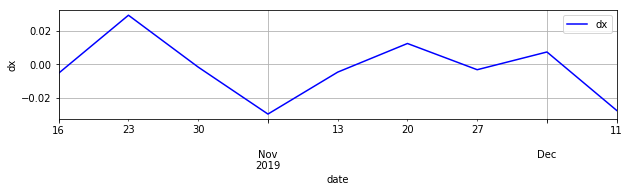

In [12]:
# Plot adjusted close over time on code
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 2 # width 10, height 8

ax = train_data[train_data['code'] == 6].plot(x='trade_date', y='dx', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("dx")

In [13]:
# 获取特征名
features = list(basic_factor_store.keys())
alpha_features = list(alpha_factor_store.keys())
# features = feature_list.uqer_features
# alpha_features = feature_list.alpha_features
# features.extend(alpha_features)

label = ['dx']

## 模型训练

In [14]:
from datetime import datetime, timedelta
from models.m1_xgb import *
from conf.configuration import xgb_conf
# import sqlalchemy as sa
# import sqlalchemy.orm as orm
from data.engines.model import Record
import xgboost as xgb
import gc

alpha_logger.info('{0} is start'.format(ref_date))

# machine learning model
## Filter Training data
## 训练集构造
trade_date_pre = ref_date - timedelta(days=1)
# trade_date_pre_80 = ref_date - timedelta(days=80)

## 1、选择调仓日当天之前(不含当天)并且在80天以内的因子数据作为训练集.
# train = train_data[(train_data.trade_date <= trade_date_pre) & (trade_date_pre_80 <= train_data.trade_date)].dropna()
## 2、选择调仓日当天之前(不含当天)的因子数据作为训练集.
train = train_data[train_data.trade_date <= trade_date_pre].dropna()
alpha_logger.info('trade_date_pre {0}'.format(trade_date_pre))

if len(train) <= 0:
    alpha_logger.info('{0} HAS NO TRAIN DATA!!!'.format(ref_date))

x_train = train[features]
y_train = train[label]
alpha_logger.info('len_x_train: {0}, len_y_train: {1}'.format(len(x_train.values), len(y_train.values)))
alpha_logger.info('X_train.shape={0}, X_test.shape = {1}'.format(np.shape(x_train), np.shape(y_train)))


2019-12-19 01:56:22,701 - ALPHA_MIND - INFO - 2019-12-18 00:00:00 is start
2019-12-19 01:56:22,736 - ALPHA_MIND - INFO - trade_date_pre 2019-12-17 00:00:00
2019-12-19 01:56:22,743 - ALPHA_MIND - INFO - len_x_train: 4500, len_y_train: 4500
2019-12-19 01:56:22,744 - ALPHA_MIND - INFO - X_train.shape=(4500, 423), X_test.shape = (4500, 1)


## 超参寻优

In [15]:
# load xgboost regression configuration
xgb_conf.xgb_config_r()
xgb_conf.cv_folds = None
xgb_conf.early_stop_round = 100
xgb_conf.max_round = 800

GPU_device = False
if GPU_device:
    # use GPUs
    xgb_conf.params.update({'tree_method': 'gpu_hist'})
alpha_logger.info("params before: {}".format(xgb_conf.params))
tic = time.time()

# hyper_parameters optimization
# opt_parameters = {'max_depth': (2, 12),
#                   'gamma': (0.001, 10.0),
#                   'min_child_weight': (0, 20),
#                   'max_delta_step': (0, 10),
#                   'subsample': (0.01, 0.99),
#                   'colsample_bytree': (0.01, 0.99)
#                  }

# opt_xgb = BayesOptimizationXGB('regression', x_train, y_train)
# params_op = opt_xgb.train_opt(opt_parameters)
# xgb_conf.params.update(params_op)
alpha_logger.info("params after: {}".format(xgb_conf.params))
alpha_logger.info("hyper params optimize time : {}".format(time.time() - tic))


2019-12-19 01:56:22,750 - ALPHA_MIND - INFO - params before: {'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 4, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2019-12-19 01:56:22,750 - ALPHA_MIND - INFO - params after: {'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 4, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2019-12-19 01:56:22,751 - ALPHA_MIND - INFO - hyper params optimize time : 0.0005707740783691406


## 模型训练

In [16]:
# model training
xgb_model = XGBooster(xgb_conf)
alpha_logger.info('xgb_model params: \n{0}'.format(xgb_model.get_params()))

best_score, best_round, best_model = xgb_model.fit(x_train, y_train)
alpha_logger.info('Training time cost {}s'.format(time.time() - tic))
alpha_logger.info('best_score = {}, best_round = {}'.format(best_score, best_round))


2019-12-19 01:56:22,756 - ALPHA_MIND - INFO - xgb_model params: 
{'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 4, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2019-12-19 01:56:22,756 - ../../../models/m1_xgb.py[line:95] - INFO: NonCrossValidation。。。。


[0]	train-rmse:0.49885	train-logloss:0.683122
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.474541	train-logloss:0.635732
[10]	train-rmse:0.451443	train-logloss:0.592659
[15]	train-rmse:0.429472	train-logloss:0.553307
[20]	train-rmse:0.408589	train-logloss:0.517255
[25]	train-rmse:0.38874	train-logloss:0.484122
[30]	train-rmse:0.369865	train-logloss:0.453569
[35]	train-rmse:0.35193	train-logloss:0.425349
[40]	train-rmse:0.33489	train-logloss:0.399225
[45]	train-rmse:0.318674	train-logloss:0.374952
[50]	train-rmse:0.303263	train-logloss:0.352388
[55]	train-rmse:0.288629	train-logloss:0.331393
[60]	train-rmse:0.274725	train-logloss:0.311816
[65]	train-rmse:0.261496	train-logloss:0.293508
[70]	train-rmse:0.248942	train-logloss:0.276407
[75]	train-rmse:0.236987	train-logloss:0.26036
[80]	train-rmse:0.225658	train-logloss:0.245354
[85]	train-rmse:0.214866	train-logloss:

2019-12-19 01:56:31,467 - ALPHA_MIND - INFO - Training time cost 8.717076063156128s
2019-12-19 01:56:31,468 - ALPHA_MIND - INFO - best_score = {'best_score': -0.417269}, best_round = 798


## 当天数据预测

In [17]:
# 取调仓日当天的因子数据作为输入.
# total_data_test_excess = train_data[train_data.trade_date == str(ref_date)]
total_data_test_excess = factor_data[factor_data.trade_date == ref_date]

if len(total_data_test_excess) <=0:
    alpha_logger.info('{} HAS NO DATA!!!'.format(ref_date))
    sys.exit()

alpha_logger.info('{0} total_data_test_excess: {1}'.format(ref_date, len(total_data_test_excess)))

# 获取调仓日当天的行业, 风险模型和基准权重数据
industry_matrix = industry_total[industry_total.trade_date == ref_date]
benchmark_weight = benchmark_total[benchmark_total.trade_date == ref_date]
risk_matrix = risk_total[risk_total.trade_date == ref_date]

total_data = pd.merge(industry_matrix, benchmark_weight, on=['code'], how='left').fillna(0.)
total_data = pd.merge(total_data, risk_matrix, on=['code'])
alpha_logger.info('{0} type_of_total_data: {1}'.format(ref_date, type(total_data)))
alpha_logger.info('{0} shape_of_total_data: {1}'.format(ref_date, np.shape(total_data)))
    
total_data_test_excess = pd.merge(total_data, total_data_test_excess, on=['code'])
alpha_logger.info('{0} len_of_total_data_test_excess: {1}'.format(ref_date, len(total_data_test_excess)))

# 股票代码
codes = total_data_test_excess.code.values.tolist()
   
# predict
# alpha_logger.info('total_data_test_excess: \n{}'.format(total_data_test_excess[['weight', 'code', 'industry']]))
x_pred = total_data_test_excess[features]
predict_xgboost = xgb_model.predict(best_model, x_pred)
# alpha_logger.info('predict_xgboost: {}'.format(predict_xgboost))
    
a = np.shape(predict_xgboost)
predict_xgboost = np.reshape(predict_xgboost, (a[0], -1)).astype(np.float64)
alpha_logger.info('shape_of_predict_xgboost: {}'.format(np.shape(predict_xgboost)))
alpha_logger.info('shape_of_predict_xgboost: {}'.format(type(predict_xgboost)))

# 收益率预测结果    
predict_xgboost_df = pd.DataFrame({'xgb_pre': list(predict_xgboost.reshape(-1))})
predict_xgboost_df['trade_date'] = ref_date
predict_xgboost_df['code'] = codes
predict_xgboost_df['code'] = predict_xgboost_df['code'].apply(lambda x: "{:06d}".format(x) + '.XSHG'
                                                              if len(str(x))==6 and str(x)[0] in '6' 
                                                              else "{:06d}".format(x) + '.XSHE')

2019-12-19 01:56:31,508 - ALPHA_MIND - INFO - 2019-12-18 00:00:00 total_data_test_excess: 500
2019-12-19 01:56:31,520 - ALPHA_MIND - INFO - 2019-12-18 00:00:00 type_of_total_data: <class 'pandas.core.frame.DataFrame'>
2019-12-19 01:56:31,521 - ALPHA_MIND - INFO - 2019-12-18 00:00:00 shape_of_total_data: (500, 74)
2019-12-19 01:56:31,528 - ALPHA_MIND - INFO - 2019-12-18 00:00:00 len_of_total_data_test_excess: 500
2019-12-19 01:56:31,544 - ALPHA_MIND - INFO - shape_of_predict_xgboost: (500, 1)
2019-12-19 01:56:31,545 - ALPHA_MIND - INFO - shape_of_predict_xgboost: <class 'numpy.ndarray'>


## 获取昨持仓信息

In [ ]:
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from data.engines.sqlengine import SQLEngine

# 获取当前持仓
engine = SQLEngine('sqlite:///./real_tune_record_without_alpha.db')
# engine = SQLEngine('sqlite:////home/jerry/workshop/projects/MultiFactors/src/stacking/notebooks/cross_section/real_tune_record.db')
# engine = SQLEngine('sqlite:////home/jerry/workshop/projects/MultiFactors/src/stacking/notebooks/cross_section/real_tune_record_without_alpha.db')
engine = SQLEngine('sqlite:///./real_tune_record_without_alpha.db')

try:
    pos_record = engine.fetch_record('pos_record')
    previous_pos = pos_record[pos_record['trade_date'] == str(ref_date_pre)]
except Exception as e:
    alpha_logger.info('pos_record Exception:{0}'.format(e))
    previous_pos = pd.DataFrame({'trade_date':[], 'weight':[],'industry':[], 'er':[],'code':[]})

alpha_logger.info('previous_pos_data: {0}, pos_len: {1}'.format(ref_date_pre, len(previous_pos)))

# 股票过滤, 组合优化之前过滤掉(未完成)
## 9:00--9:25之间进行涨跌停股票的实时筛选

# 导入昨持仓并与股票池中所有股票合并, 
previous_pos = total_data_test_excess[['code']].merge(previous_pos, on=['code'], how='left').fillna(0)
alpha_logger.info('previous_pos:\n {}'.format(previous_pos.sort_values(by='weight', ascending=False)))

## 组合优化

In [19]:
# Constraintes settings
industry_names = industry_list(industry_name, industry_level)
constraint_risk = ['EARNYILD', 'LIQUIDTY', 'GROWTH', 'SIZE', 'SIZENL', 'BETA', 'MOMENTUM'] + industry_names

total_risk_names = constraint_risk + ['benchmark', 'total']

b_type = []
l_val = []
u_val = []

for name in total_risk_names:
    if name == 'benchmark':
        b_type.append(BoundaryType.RELATIVE)
        l_val.append(0.0)
        u_val.append(1.0)
    elif name == 'total':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.0)
        u_val.append(0.0)
    elif name == 'SIZE':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.1)
        u_val.append(0.1)
    elif name == 'SIZENL':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.1)
        u_val.append(-0.1)
    elif name in industry_names:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.005)
        u_val.append(0.005)
    else:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-1.0)
        u_val.append(1.0)
bounds = create_box_bounds(total_risk_names, b_type, l_val, u_val)


In [20]:
benchmark_w = total_data_test_excess.weight.values
alpha_logger.info('type_of_benchmark_w: {}, shape_of_benchmark_w: {}'.format(type(benchmark_w), 
                                                                             np.shape(benchmark_w)))
is_in_benchmark = (benchmark_w > 0.).astype(float).reshape((-1, 1))

# 风险模型数据合并
weight_gap = 0.02
total_risk_exp = np.concatenate([total_data_test_excess[constraint_risk].values.astype(float),
                                 is_in_benchmark,
                                 np.ones_like(is_in_benchmark)],
                                axis=1)

alpha_logger.info('shape_of_total_risk_exp_pre: {}'.format(np.shape(total_risk_exp)))
total_risk_exp = pd.DataFrame(total_risk_exp, columns=total_risk_names)
alpha_logger.info('shape_of_total_risk_exp: {}'.format(np.shape(total_risk_exp)))

constraints = LinearConstraints(bounds, total_risk_exp, benchmark_w)
alpha_logger.info('constraints: {0} in {1}'.format(np.shape(constraints.risk_targets()), ref_date))
    
lbound = np.maximum(0., benchmark_w - weight_gap)
ubound = weight_gap + benchmark_w
alpha_logger.info('lbound: {0} in {1}'.format(np.shape(lbound), ref_date))
alpha_logger.info('ubound: {0} in {1}'.format(np.shape(ubound), ref_date))

# 组合优化
executor = NaiveExecutor()
trade_dates = []
current_pos = pd.DataFrame()
tune_record = pd.DataFrame()

target_pos, _ = er_portfolio_analysis(predict_xgboost, 
                                      total_data_test_excess['industry'].values,
                                      None,
                                      constraints,
                                      False,
                                      benchmark_w,
                                      method='risk_neutral',
                                      lbound=lbound,
                                      ubound=ubound,
                                      turn_over_target=0.5,
                                      current_pos=previous_pos.weight.values)
                  
alpha_logger.info('shape_of_target_pos: {}'.format(np.shape(target_pos)))
alpha_logger.info('len_codes:{}'.format(np.shape(codes)))
target_pos['code'] = codes
# alpha_logger.info('target_pos: \n{}'.format(target_pos))

# 持仓信息
result = target_pos
result['trade_date'] = ref_date
tune_record = tune_record.append(result)
alpha_logger.info('len_result: {}'.format(len(result)))

# 换手率计算
executor.set_current(previous_pos)
turn_over_org, current_pos = executor.execute(target_pos=target_pos)
alpha_logger.info('turn_over_org: {}'.format(turn_over_org))
current_pos['trade_date'] = str(ref_date)

# 保存当前持仓信息   
engine.del_historical_data('pos_record', str(ref_date))  # 删除同日期的历史数据
engine.write_data('pos_record', current_pos)

turn_over = turn_over_org / sum(target_pos.weight.values)
alpha_logger.info('turn_over: {}'.format(turn_over))
# turn_overs.append(turn_over)

alpha_logger.info('{} is finished'.format(ref_date))


2019-12-19 01:56:31,610 - ALPHA_MIND - INFO - type_of_benchmark_w: <class 'numpy.ndarray'>, shape_of_benchmark_w: (500,)
2019-12-19 01:56:31,612 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2019-12-19 01:56:31,613 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2019-12-19 01:56:31,615 - ALPHA_MIND - INFO - constraints: (2, 37) in 2019-12-18 00:00:00
2019-12-19 01:56:31,616 - ALPHA_MIND - INFO - lbound: (500,) in 2019-12-18 00:00:00
2019-12-19 01:56:31,616 - ALPHA_MIND - INFO - ubound: (500,) in 2019-12-18 00:00:00
2019-12-19 01:56:31,626 - ALPHA_MIND - INFO - shape_of_target_pos: (500, 3)
2019-12-19 01:56:31,627 - ALPHA_MIND - INFO - len_codes:(500,)
2019-12-19 01:56:31,630 - ALPHA_MIND - INFO - len_result: 500
2019-12-19 01:56:31,637 - ALPHA_MIND - INFO - turn_over_org: 0.9999299677325767


OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: http://sqlalche.me/e/e3q8)

In [ ]:
# TOP N
# tune_record['code'] = tune_record['code'].apply(lambda x: "{:06d}".format(x) + '.XSHG' 
#                                                 if len(str(x))==6 and str(x)[0] in '6' 
#                                                 else "{:06d}".format(x) + '.XSHE')
# tune_record.sort_values(by='weight', ascending=False)[:20]

In [ ]:
# TOP N
tune_record['code'] = tune_record['code'].apply(lambda x: "{:06d}".format(x) + '.SH' 
                                                if len(str(x))==6 and str(x)[0] in '6' 
                                                else "{:06d}".format(x) + '.SZ')
tune_record.sort_values(by='weight', ascending=False)[:50]

In [ ]:
tune_record.sort_values(by='er', ascending=False)[:50]


In [ ]:
res = tune_record.sort_values(by='weight', ascending=False)[:50]
res['weight'] = res['weight'] / res['weight'].sum()

In [ ]:
res.to_csv('base20191219.csv', encoding='utf_8_sig')